# Model Training and Evaluation

This notebook loads the preprocessed shot data, trains several xG models (with and without geometry features), and evaluates them against actual goals and the StatsBomb xG values.

## Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, brier_score_loss

from xgboost import XGBClassifier

import matplotlib.pyplot as plt


## Load preprocessed shots

In [18]:
# world cup 2018 data frame
data_path = Path("shots_featured_wc2018.csv")
shots_featured = pd.read_csv(data_path)
display(shots_featured.head())

# Euro 2020 data frame

eu_data_path = Path("shots_featured_eu2020.csv")
shots_eu = pd.read_csv(eu_data_path)
display(shots_eu.head())


# WC 2022 data frame

WC_22_data_path = Path("shots_WC_22.csv")
shots_WC_22 = pd.read_csv(WC_22_data_path)
display(shots_WC_22)

,shot_statsbomb_xg,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,is_goal,distance,angle
0,0.009816,62.0,93.0,40.0,0,0,0,0,115.0,18.0,0,22.561028,0.064071
1,0.038204,87.0,93.0,40.0,0,0,0,0,112.0,54.0,0,16.124515,0.202196
2,0.045128,87.0,93.0,40.0,0,0,0,0,98.0,37.0,0,22.203603,0.283785
3,0.625074,87.0,93.0,37.0,1,0,0,0,119.0,36.0,0,4.123106,0.758049
4,0.021760,87.0,93.0,40.0,0,0,0,0,97.0,56.0,0,28.017851,0.187756


,shot_statsbomb_xg,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,is_goal,distance,angle
0,0.030169,87.0,93.0,38.0,0,0,0,0,91.9,39.0,0,28.117788,0.226500
1,0.021315,87.0,91.0,38.0,0,1,0,0,96.5,29.7,0,25.658137,0.228027
2,0.047888,62.0,93.0,40.0,0,0,0,0,97.8,25.9,0,26.299240,0.205564
3,0.100356,87.0,93.0,37.0,0,0,0,0,112.0,40.7,0,8.030567,0.756483
4,0.008758,87.0,93.0,38.0,0,0,0,0,99.7,58.6,0,27.532708,0.172017


,shot_statsbomb_xg,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,is_goal,distance,angle
0,0.036566,87.0,91.0,38.0,0,1,0,0,96.0,38.8,0,24.029981,0.264461
1,0.353289,87.0,91.0,38.0,0,1,0,0,113.1,40.7,0,6.935416,0.862058
2,0.069527,87.0,91.0,40.0,0,1,0,0,103.8,41.9,0,16.311039,0.385068
3,0.081609,87.0,93.0,37.0,0,0,0,0,112.2,36.8,0,8.430896,0.687124
4,0.030002,87.0,93.0,38.0,0,0,0,0,97.8,51.5,0,25.001800,0.227095
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,0.568312,87.0,93.0,37.0,0,0,0,0,118.2,43.9,0,4.295346,0.951615
1449,0.028724,87.0,93.0,40.0,0,0,0,0,102.5,24.2,0,23.577320,0.202448
1450,0.145394,87.0,93.0,37.0,0,0,0,1,114.4,36.8,0,6.449806,0.851966
1451,0.028684,87.0,93.0,40.0,0,0,0,0,95.0,30.2,0,26.852188,0.221408


## Define target and feature sets

We keep `shot_statsbomb_xg` and `is_goal` for evaluation. We build two feature matrices:

- **Raw features** (`X_raw`): all features *except* distance and angle (this mimics your early models).
- **Featured geometry** (`X_feat`): all features including distance and angle.

In [19]:
# Target
y = shots_featured["is_goal"].astype(int) # world cup data target
y_eu = shots_eu["is_goal"] # Euro data target 
y_wc_22 = shots_WC_22["is_goal"]

# Base feature set (drop labels/statsbomb xg)
X_full = shots_featured.drop(["shot_statsbomb_xg", "is_goal"], axis=1)

X_full_eu = shots_eu.drop(["shot_statsbomb_xg","is_goal"],axis=1)

X_full_wc_22 = shots_WC_22.drop(["shot_statsbomb_xg","is_goal"],axis=1)

# Raw features: no distance & angle
drop_geom = [col for col in ["distance", "angle"] if col in X_full.columns]
X_raw = X_full.drop(drop_geom, axis=1)


X_raw_eu = X_full_eu.drop(["distance","angle"],axis=1)

X_raw_wc_22 = X_full_wc_22.drop(["distance","angle"],axis=1)

# Featured geometry = all features
X_feat = X_full.copy()

X_feat_eu = X_full_eu

X_feat_wc_22 = X_full_wc_22

display(X_raw.head(), X_feat.head(), X_raw_eu.head(), X_feat_eu.head(),X_raw_wc_22.head(),X_feat_wc_22.head())


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y
0,62.0,93.0,40.0,0,0,0,0,115.0,18.0
1,87.0,93.0,40.0,0,0,0,0,112.0,54.0
2,87.0,93.0,40.0,0,0,0,0,98.0,37.0
3,87.0,93.0,37.0,1,0,0,0,119.0,36.0
4,87.0,93.0,40.0,0,0,0,0,97.0,56.0


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,distance,angle
0,62.0,93.0,40.0,0,0,0,0,115.0,18.0,22.561028,0.064071
1,87.0,93.0,40.0,0,0,0,0,112.0,54.0,16.124515,0.202196
2,87.0,93.0,40.0,0,0,0,0,98.0,37.0,22.203603,0.283785
3,87.0,93.0,37.0,1,0,0,0,119.0,36.0,4.123106,0.758049
4,87.0,93.0,40.0,0,0,0,0,97.0,56.0,28.017851,0.187756


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y
0,87.0,93.0,38.0,0,0,0,0,91.9,39.0
1,87.0,91.0,38.0,0,1,0,0,96.5,29.7
2,62.0,93.0,40.0,0,0,0,0,97.8,25.9
3,87.0,93.0,37.0,0,0,0,0,112.0,40.7
4,87.0,93.0,38.0,0,0,0,0,99.7,58.6


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,distance,angle
0,87.0,93.0,38.0,0,0,0,0,91.9,39.0,28.117788,0.226500
1,87.0,91.0,38.0,0,1,0,0,96.5,29.7,25.658137,0.228027
2,62.0,93.0,40.0,0,0,0,0,97.8,25.9,26.299240,0.205564
3,87.0,93.0,37.0,0,0,0,0,112.0,40.7,8.030567,0.756483
4,87.0,93.0,38.0,0,0,0,0,99.7,58.6,27.532708,0.172017


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y
0,87.0,91.0,38.0,0,1,0,0,96.0,38.8
1,87.0,91.0,38.0,0,1,0,0,113.1,40.7
2,87.0,91.0,40.0,0,1,0,0,103.8,41.9
3,87.0,93.0,37.0,0,0,0,0,112.2,36.8
4,87.0,93.0,38.0,0,0,0,0,97.8,51.5


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,distance,angle
0,87.0,91.0,38.0,0,1,0,0,96.0,38.8,24.029981,0.264461
1,87.0,91.0,38.0,0,1,0,0,113.1,40.7,6.935416,0.862058
2,87.0,91.0,40.0,0,1,0,0,103.8,41.9,16.311039,0.385068
3,87.0,93.0,37.0,0,0,0,0,112.2,36.8,8.430896,0.687124
4,87.0,93.0,38.0,0,0,0,0,97.8,51.5,25.001800,0.227095


## Train/test split (shared indices)

We split once using `X_feat` and `y`, then use the resulting indices to build matching train/test sets for `X_raw`.


In [4]:
X_train_feat, X_test_feat, y_train, y_test = train_test_split(
    X_feat, y, test_size=0.2, random_state=42
)

# Align raw feature splits using the same indices
X_train_raw = X_raw.loc[X_train_feat.index]
X_test_raw = X_raw.loc[X_test_feat.index]

X_train_feat.shape, X_train_raw.shape, X_test_feat.shape, X_test_raw.shape


((1333, 11), (1333, 9), (334, 11), (334, 9))

## 1. Logistic Regression (raw features, no geometry)

Logistic regression model based on x, y and categorical/boolean features, without distance and angle.

In [5]:
lr_raw = LogisticRegression(max_iter=2000)
lr_raw.fit(X_train_raw, y_train)

lr_raw_pred_train = lr_raw.predict_proba(X_train_raw)[:, 1]
lr_raw_pred_test = lr_raw.predict_proba(X_test_raw)[:, 1]


## 2. XGBoost (raw features, no geometry)

XGBoost model that only used raw coordinates and simple features.

In [6]:
xgb_raw = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
)

xgb_raw.fit(X_train_raw, y_train)

xgb_raw_pred_train = xgb_raw.predict_proba(X_train_raw)[:, 1]
xgb_raw_pred_test = xgb_raw.predict_proba(X_test_raw)[:, 1]


## 3. Logistic Regression (featured geometry, unscaled)

Lr_featured model: distance and angle included, but no scaling.

In [7]:
lr_featured = LogisticRegression(max_iter=2000)
lr_featured.fit(X_train_feat, y_train)

lr_featured_pred_train = lr_featured.predict_proba(X_train_feat)[:, 1]
lr_featured_pred_test = lr_featured.predict_proba(X_test_feat)[:, 1]


## 4. XGBoost (featured geometry)

Xgb_featured model that uses distance and angle.

In [8]:
xgb_featured = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
)

xgb_featured.fit(X_train_feat, y_train)

xgb_featured_pred_train = xgb_featured.predict_proba(X_train_feat)[:, 1]
xgb_featured_pred_test = xgb_featured.predict_proba(X_test_feat)[:, 1]


## 5. Scaled Logistic Regression (featured geometry)

We standardize all features and then fit logistic regression. This corresponds to the `lr_scaled` model.

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled = scaler.transform(X_test_feat)

lr_scaled = LogisticRegression(max_iter=2000)
lr_scaled.fit(X_train_scaled, y_train)

lr_scaled_pred_train = lr_scaled.predict_proba(X_train_scaled)[:, 1]
lr_scaled_pred_test = lr_scaled.predict_proba(X_test_scaled)[:, 1]


## Build comparison dataframe (test set)

We collect StatsBomb xG, actual goals, and predictions from all five models.

In [10]:
comparison_df = pd.DataFrame({
    "shot_statsbomb_xg": shots_featured.loc[X_test_feat.index, "shot_statsbomb_xg"].values,
    "is_goal": y_test.values,
    "lr_raw": lr_raw_pred_test,
    "xgb_raw": xgb_raw_pred_test,
    "lr_featured": lr_featured_pred_test,
    "xgb_featured": xgb_featured_pred_test,
    "lr_scaled": lr_scaled_pred_test,
})

comparison_df.head()


,shot_statsbomb_xg,is_goal,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
0,0.006300,0,0.004521,0.003367,0.006573,0.000699,0.007732
1,0.046135,0,0.100994,0.116578,0.061676,0.031585,0.064420
2,0.042731,0,0.189735,0.094683,0.082968,0.017242,0.089929
3,0.280159,0,0.164179,0.478216,0.232624,0.230073,0.216934
4,0.009661,0,0.042033,0.018602,0.006363,0.052587,0.009700


## Summary statistics

In [11]:
comparison_df.describe()


,shot_statsbomb_xg,is_goal,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,0.104808,0.089820,0.100015,0.093444,0.096997,0.094095,0.097356
std,0.138881,0.286353,0.076117,0.142498,0.104049,0.156556,0.108729
min,0.005267,0.000000,0.003878,0.001059,0.001607,0.000655,0.002509
25%,0.029038,0.000000,0.043905,0.012906,0.029273,0.010890,0.032421
50%,0.059884,0.000000,0.081624,0.034054,0.063184,0.030484,0.061062
75%,0.118071,0.000000,0.139016,0.112182,0.125616,0.090233,0.120973
max,0.929318,1.000000,0.423221,0.790708,0.751864,0.769223,0.855332


## Total xG vs actual goals

In [12]:
print("Actual goals (test):", comparison_df["is_goal"].sum())
print("StatsBomb total xG (test):", comparison_df["shot_statsbomb_xg"].sum())
print("LR raw total xG (test):", comparison_df["lr_raw"].sum())
print("XGB raw total xG (test):", comparison_df["xgb_raw"].sum())
print("LR featured total xG (test):", comparison_df["lr_featured"].sum())
print("XGB featured total xG (test):", comparison_df["xgb_featured"].sum())
print("LR scaled total xG (test):", comparison_df["lr_scaled"].sum())


Actual goals (test): 30
StatsBomb total xG (test): 35.005826772000006
LR raw total xG (test): 33.405058288389256
XGB raw total xG (test): 31.210167
LR featured total xG (test): 32.39711176300707
XGB featured total xG (test): 31.42786
LR scaled total xG (test): 32.51674715831909


## Correlation with StatsBomb xG

In [13]:
comparison_df[[
    "shot_statsbomb_xg",
    "lr_raw",
    "xgb_raw",
    "lr_featured",
    "xgb_featured",
    "lr_scaled",
]].corr()


,shot_statsbomb_xg,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
shot_statsbomb_xg,1.000000,0.550105,0.804426,0.760779,0.772399,0.753106
lr_raw,0.550105,1.000000,0.544327,0.733098,0.531023,0.740777
xgb_raw,0.804426,0.544327,1.000000,0.717781,0.885781,0.708347
lr_featured,0.760779,0.733098,0.717781,1.000000,0.704490,0.994481
xgb_featured,0.772399,0.531023,0.885781,0.704490,1.000000,0.700035
lr_scaled,0.753106,0.740777,0.708347,0.994481,0.700035,1.000000


## AUC and Brier scores vs actual goals

In [14]:
auc_lr_raw = roc_auc_score(comparison_df["is_goal"], comparison_df["lr_raw"])
auc_xgb_raw = roc_auc_score(comparison_df["is_goal"], comparison_df["xgb_raw"])
auc_lr_featured = roc_auc_score(comparison_df["is_goal"], comparison_df["lr_featured"])
auc_xgb_featured = roc_auc_score(comparison_df["is_goal"], comparison_df["xgb_featured"])
auc_lr_scaled = roc_auc_score(comparison_df["is_goal"], comparison_df["lr_scaled"])

brier_lr_raw = brier_score_loss(comparison_df["is_goal"], comparison_df["lr_raw"])
brier_xgb_raw = brier_score_loss(comparison_df["is_goal"], comparison_df["xgb_raw"])
brier_lr_featured = brier_score_loss(comparison_df["is_goal"], comparison_df["lr_featured"])
brier_xgb_featured = brier_score_loss(comparison_df["is_goal"], comparison_df["xgb_featured"])
brier_lr_scaled = brier_score_loss(comparison_df["is_goal"], comparison_df["lr_scaled"])

print("=== AUC ===")
print("LR raw:       ", auc_lr_raw)
print("XGB raw:      ", auc_xgb_raw)
print("LR featured:  ", auc_lr_featured)
print("XGB featured: ", auc_xgb_featured)
print("LR scaled:    ", auc_lr_scaled)

print("\n=== Brier ===")
print("LR raw:       ", brier_lr_raw)
print("XGB raw:      ", brier_xgb_raw)
print("LR featured:  ", brier_lr_featured)
print("XGB featured: ", brier_xgb_featured)
print("LR scaled:    ", brier_lr_scaled)


=== AUC ===
LR raw:        0.6846491228070176
XGB raw:       0.6907894736842106
LR featured:   0.7190789473684212
XGB featured:  0.7218201754385966
LR scaled:     0.7219298245614035

=== Brier ===
LR raw:        0.07707380221135209
XGB raw:       0.07264690682052297
LR featured:   0.07328070540402781
XGB featured:  0.07557210672783476
LR scaled:     0.07306360073765109


## Scatterplots vs StatsBomb xG

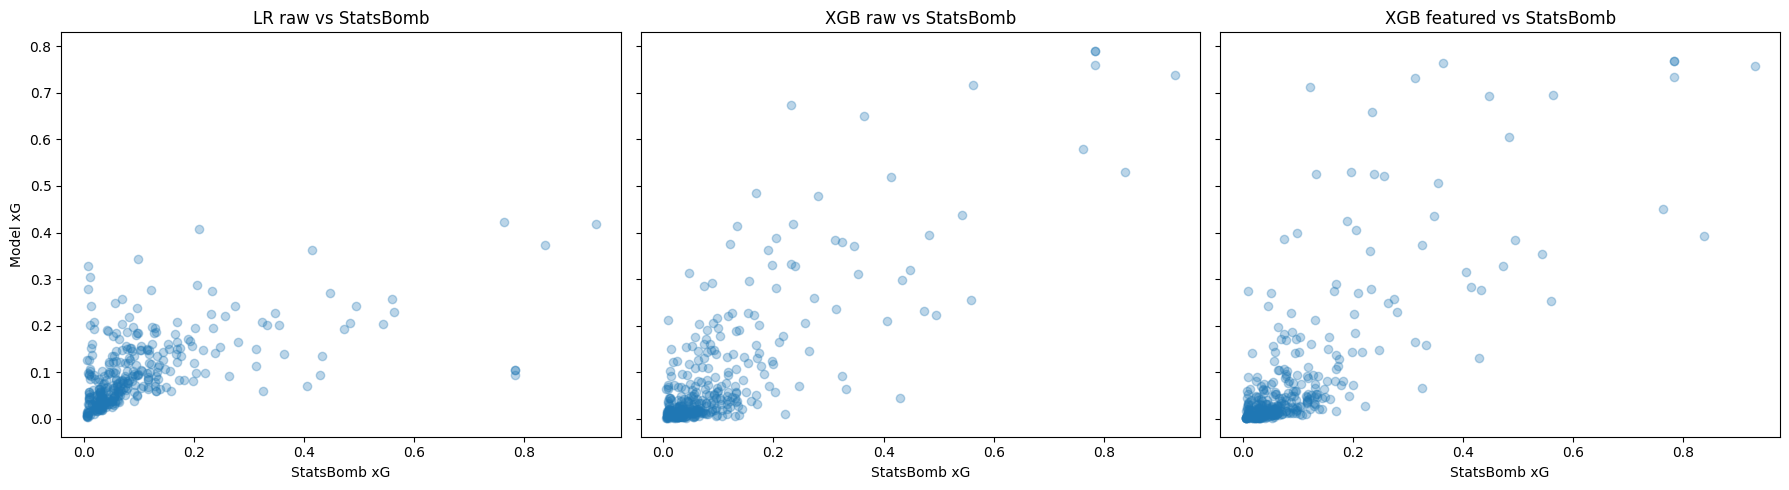

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

axes[0].scatter(comparison_df["shot_statsbomb_xg"], comparison_df["lr_raw"], alpha=0.3)
axes[0].set_title("LR raw vs StatsBomb")
axes[0].set_xlabel("StatsBomb xG")
axes[0].set_ylabel("Model xG")

axes[1].scatter(comparison_df["shot_statsbomb_xg"], comparison_df["xgb_raw"], alpha=0.3)
axes[1].set_title("XGB raw vs StatsBomb")
axes[1].set_xlabel("StatsBomb xG")

axes[2].scatter(comparison_df["shot_statsbomb_xg"], comparison_df["xgb_featured"], alpha=0.3)
axes[2].set_title("XGB featured vs StatsBomb")
axes[2].set_xlabel("StatsBomb xG")

plt.tight_layout()
plt.show()


## (Optional) Save models to disk


In [16]:
# import joblib
# joblib.dump(lr_raw, "lr_raw_wc2018.pkl")
# joblib.dump(xgb_raw, "xgb_raw_wc2018.pkl")
# joblib.dump(lr_featured, "lr_featured_wc2018.pkl")
# joblib.dump(xgb_featured, "xgb_featured_wc2018.pkl")
# joblib.dump(lr_scaled, "lr_scaled_wc2018.pkl")
# joblib.dump(scaler, "scaler_wc2018.pkl")
# print("Saved models and scaler to disk.")


# Models evaluation on Euro 2020

In [17]:
# Logistic Regression (raw)
lr_raw_pred_eu = lr_raw.predict_proba(X_raw_eu)[:, 1]

# XGBoost (raw)
xgb_raw_pred_eu = xgb_raw.predict_proba(X_raw_eu)[:, 1]

# Logistic Regression (featured)
lr_feat_pred_eu = lr_featured.predict_proba(X_feat_eu)[:, 1]

# XGBoost (featured)
xgb_feat_pred_eu = xgb_featured.predict_proba(X_feat_eu)[:, 1]

# LR Scaled
X_eu_scaled = scaler.transform(X_feat_eu)
lr_scaled_pred_eu = lr_scaled.predict_proba(X_eu_scaled)[:, 1]


# ==========================
# BUILD COMPARISON TABLE
# ==========================

eu_eval = pd.DataFrame({
    "statsbomb_xg": shots_eu["shot_statsbomb_xg"],
    "is_goal": y_eu,
    "lr_raw": lr_raw_pred_eu,
    "xgb_raw": xgb_raw_pred_eu,
    "lr_featured": lr_feat_pred_eu,
    "xgb_featured": xgb_feat_pred_eu,
    "lr_scaled": lr_scaled_pred_eu
})

display(eu_eval.head())


# ==========================
# TOTAL GOALS & XG SUMS
# ==========================

print("=== EURO 2020 TOTALS ===")
print(f"Actual Goals: {eu_eval['is_goal'].sum():.2f}")
print(f"StatsBomb xG: {eu_eval['statsbomb_xg'].sum():.2f}")
print(f"LR raw xG: {eu_eval['lr_raw'].sum():.2f}")
print(f"XGB raw xG: {eu_eval['xgb_raw'].sum():.2f}")
print(f"LR featured xG: {eu_eval['lr_featured'].sum():.2f}")
print(f"XGB featured xG: {eu_eval['xgb_featured'].sum():.2f}")
print(f"LR scaled xG: {eu_eval['lr_scaled'].sum():.2f}")


# ==========================
# AUC + BRIER SCORES
# ==========================

print("\n=== EURO 2020 AUC & Brier ===")

models = ["lr_raw", "xgb_raw", "lr_featured", "xgb_featured", "lr_scaled"]

for m in models:
    auc = roc_auc_score(eu_eval["is_goal"], eu_eval[m])
    brier = brier_score_loss(eu_eval["is_goal"], eu_eval[m])
    print(f"{m:15} AUC: {auc:.4f}   Brier: {brier:.4f}")

,statsbomb_xg,is_goal,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
0,0.030169,0,0.019389,0.008783,0.025583,0.032158,0.025986
1,0.021315,0,0.049139,0.009144,0.029515,0.007104,0.032338
2,0.047888,0,0.086222,0.010739,0.059623,0.003650,0.064149
3,0.100356,0,0.146564,0.156174,0.263471,0.147764,0.256568
4,0.008758,0,0.050915,0.066121,0.019041,0.116477,0.023986


=== EURO 2020 TOTALS ===
Actual Goals: 131.00
StatsBomb xG: 133.40
LR raw xG: 123.71
XGB raw xG: 119.47
LR featured xG: 123.46
XGB featured xG: 112.76
LR scaled xG: 122.58

=== EURO 2020 AUC & Brier ===
lr_raw          AUC: 0.7033   Brier: 0.0881
xgb_raw         AUC: 0.7362   Brier: 0.0894
lr_featured     AUC: 0.7650   Brier: 0.0824
xgb_featured    AUC: 0.7368   Brier: 0.0905
lr_scaled       AUC: 0.7615   Brier: 0.0826


In [20]:
# ======================================
# PREDICTIONS FOR WC 2022 (identical to EURO)
# ======================================

# Logistic Regression (raw)
lr_raw_pred_wc_22 = lr_raw.predict_proba(X_raw_wc_22)[:, 1]

# XGBoost (raw)
xgb_raw_pred_wc_22 = xgb_raw.predict_proba(X_raw_wc_22)[:, 1]

# Logistic Regression (featured)
lr_feat_pred_wc_22 = lr_featured.predict_proba(X_feat_wc_22)[:, 1]

# XGBoost (featured)
xgb_feat_pred_wc_22 = xgb_featured.predict_proba(X_feat_wc_22)[:, 1]

# LR Scaled
X_wc_22_scaled = scaler.transform(X_feat_wc_22)
lr_scaled_pred_wc_22 = lr_scaled.predict_proba(X_wc_22_scaled)[:, 1]


# ======================================
# BUILD COMPARISON TABLE
# ======================================

wc_22_eval = pd.DataFrame({
    "statsbomb_xg": shots_WC_22["shot_statsbomb_xg"],
    "is_goal": y_wc_22,
    "lr_raw": lr_raw_pred_wc_22,
    "xgb_raw": xgb_raw_pred_wc_22,
    "lr_featured": lr_feat_pred_wc_22,
    "xgb_featured": xgb_feat_pred_wc_22,
    "lr_scaled": lr_scaled_pred_wc_22
})

display(wc_22_eval.head())


# ======================================
# TOTAL GOALS & XG SUMS
# ======================================

print("=== WORLD CUP 2022 TOTALS ===")
print(f"Actual Goals: {wc_22_eval['is_goal'].sum():.2f}")
print(f"StatsBomb xG: {wc_22_eval['statsbomb_xg'].sum():.2f}")
print(f"LR raw xG: {wc_22_eval['lr_raw'].sum():.2f}")
print(f"XGB raw xG: {wc_22_eval['xgb_raw'].sum():.2f}")
print(f"LR featured xG: {wc_22_eval['lr_featured'].sum():.2f}")
print(f"XGB featured xG: {wc_22_eval['xgb_featured'].sum():.2f}")
print(f"LR scaled xG: {wc_22_eval['lr_scaled'].sum():.2f}")


# ======================================
# AUC + BRIER SCORES
# ======================================

print("\n=== WORLD CUP 2022 AUC & Brier ===")

models = ["lr_raw", "xgb_raw", "lr_featured", "xgb_featured", "lr_scaled"]

for m in models:
    auc = roc_auc_score(wc_22_eval["is_goal"], wc_22_eval[m])
    brier = brier_score_loss(wc_22_eval["is_goal"], wc_22_eval[m])
    print(f"{m:15} AUC: {auc:.4f}   Brier: {brier:.4f}")


,statsbomb_xg,is_goal,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
0,0.036566,0,0.050310,0.030390,0.052793,0.008314,0.051514
1,0.353289,0,0.249420,0.593617,0.358699,0.289725,0.359184
2,0.069527,0,0.109397,0.012076,0.132185,0.019914,0.121523
3,0.081609,0,0.145052,0.107629,0.222992,0.046209,0.217838
4,0.030002,0,0.039605,0.006563,0.035117,0.004794,0.036971


=== WORLD CUP 2022 TOTALS ===
Actual Goals: 169.00
StatsBomb xG: 155.90
LR raw xG: 150.41
XGB raw xG: 145.39
LR featured xG: 147.74
XGB featured xG: 133.21
LR scaled xG: 147.21

=== WORLD CUP 2022 AUC & Brier ===
lr_raw          AUC: 0.7181   Brier: 0.0968
xgb_raw         AUC: 0.7591   Brier: 0.0895
lr_featured     AUC: 0.7817   Brier: 0.0894
xgb_featured    AUC: 0.7560   Brier: 0.0914
lr_scaled       AUC: 0.7798   Brier: 0.0898
